In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
import torchvision.models.segmentation as models
import matplotlib.pyplot as plt


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ozguraslank/brain-stroke-ct-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-stroke-ct-dataset


In [17]:
import numpy as np
# Paths
image_dir = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Bleeding/PNG"
mask_dir = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset/Bleeding/OVERLAY"


# Dataset
class StrokeSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(".png")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.images[idx])

      # Load images
      image = Image.open(image_path).convert("RGB")
      mask_img = Image.open(mask_path).convert("RGB")  # Keep RGB for overlay

      # Extract red channel from overlay image
      mask_array = np.array(mask_img)

      # Create binary mask where predominantly red pixels are positive
      # Extract red component while ensuring other channels are low
      red_mask = (mask_array[:,:,0] > 150) & (mask_array[:,:,1] < 100) & (mask_array[:,:,2] < 100)

      # Convert to PIL for transformation
      binary_mask = Image.fromarray(red_mask.astype(np.uint8) * 255)

      # Apply transforms
      image_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])(image)
      mask_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])(binary_mask)

      return image_tensor, mask_tensor

# Transforms
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# Loaders
dataset = StrokeSegmentationDataset(image_dir, mask_dir, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True,drop_last=True)


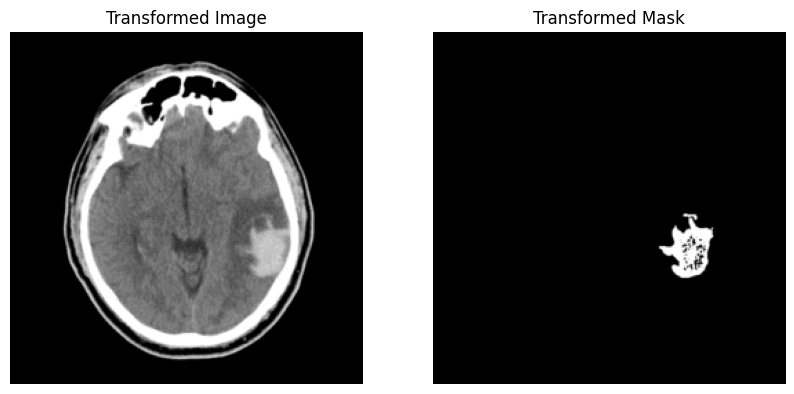

In [ ]:
import matplotlib.pyplot as plt

# One sample from dataset
sample_img, sample_mask = dataset[1]

# Convert tensors to numpy
img_np = sample_img.permute(1, 2, 0).numpy()
mask_np = sample_mask.squeeze().numpy()

# Plot original image and its mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Transformed Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Transformed Mask")
plt.imshow(mask_np, cmap='gray')
plt.axis("off")

plt.show()


In [18]:

# Model (pretrained DeepLabV3)
model = models.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # binary output
model = model.cuda()

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0
    for images, masks in dataloader:
        images, masks = images.cuda(), masks.cuda()
        outputs = model(images)['out']

        loss = criterion(outputs.squeeze(1), masks.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")


    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Average Loss: 0.2467
Epoch 1, Loss: 67.3449
Epoch 2, Average Loss: 0.0813
Epoch 2, Loss: 22.2065
Epoch 3, Average Loss: 0.0423
Epoch 3, Loss: 11.5438
Epoch 4, Average Loss: 0.0280
Epoch 4, Loss: 7.6461
Epoch 5, Average Loss: 0.0218
Epoch 5, Loss: 5.9432
Epoch 6, Average Loss: 0.0174
Epoch 6, Loss: 4.7443
Epoch 7, Average Loss: 0.0148
Epoch 7, Loss: 4.0377
Epoch 8, Average Loss: 0.0131
Epoch 8, Loss: 3.5759
Epoch 9, Average Loss: 0.0116
Epoch 9, Loss: 3.1747
Epoch 10, Average Loss: 0.0108
Epoch 10, Loss: 2.9413


In [19]:
torch.save(model.state_dict(), "deeplabv3_final_hem.pt")


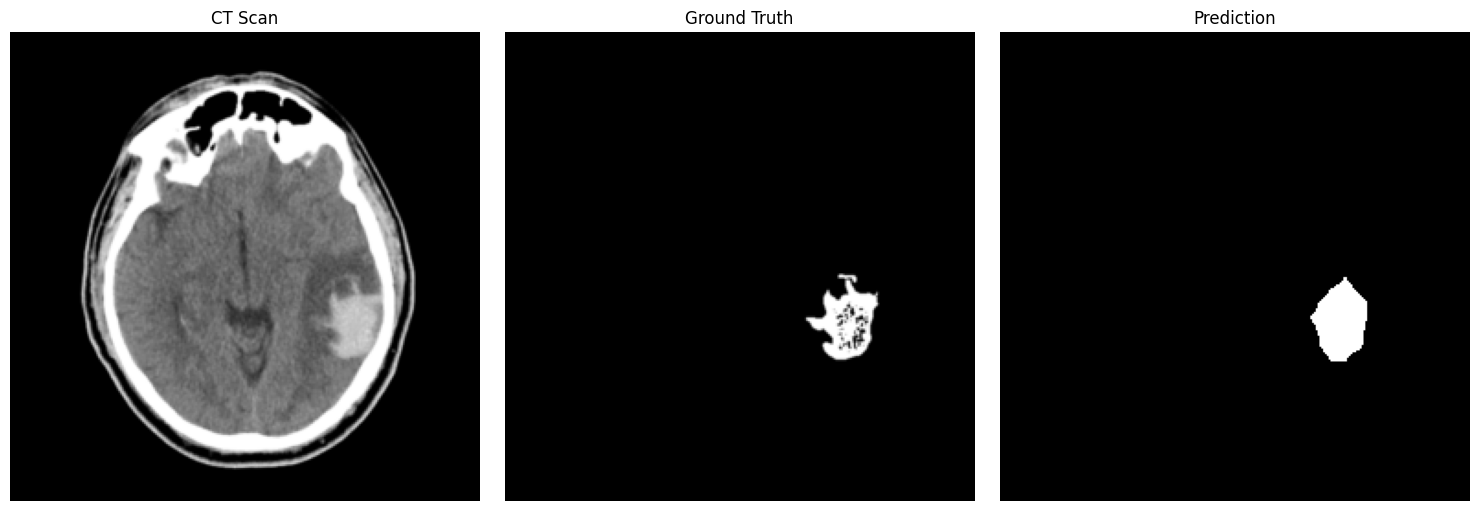

In [21]:
import matplotlib.pyplot as plt
import torch

# Fix the typo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set model to evaluation mode
model.eval()

with torch.no_grad():
    # Get sample data
    img, mask = dataset[1]

    # Add batch dimension and move to correct device
    img_input = img.unsqueeze(0).to(device)

    # Get prediction
    prediction = model(img_input)['out']  # DeepLabV3 returns a dict with 'out' key

    # Apply sigmoid and convert to binary mask
    prediction = torch.sigmoid(prediction).cpu().squeeze().numpy()
    binary_prediction = (prediction > 0.5).astype(float)

    # Convert tensors for visualization
    img_display = img.permute(1, 2, 0).cpu().numpy()  # Change from [C,H,W] to [H,W,C]
    mask_display = mask.squeeze().cpu().numpy()

# Create visualization
plt.figure(figsize=(15, 5))

# Original image - use proper normalization for CT
plt.subplot(1, 3, 1)
plt.imshow(img_display, cmap='gray' if img_display.shape[-1] == 1 else None)
plt.title("CT Scan")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(mask_display, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

# Model prediction
plt.subplot(1, 3, 3)
plt.imshow(binary_prediction, cmap='gray')
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [23]:
import torch
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryAccuracy

# Move model to eval mode
model.eval()

# Metrics
iou_metric = BinaryJaccardIndex().to("cuda")
dice_metric = BinaryF1Score().to("cuda")
acc_metric = BinaryAccuracy().to("cuda")

# Accumulate metrics
with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.cuda(), masks.cuda()
        outputs = model(images)['out']
        preds = torch.sigmoid(outputs).squeeze(1) > 0.5

        iou_metric.update(preds.int(), masks.squeeze(1).int())
        dice_metric.update(preds.int(), masks.squeeze(1).int())
        acc_metric.update(preds.int(), masks.squeeze(1).int())

# Final score
iou_score = iou_metric.compute().item()
dice_score = dice_metric.compute().item()
acc_score = acc_metric.compute().item()

print(f"IoU: {iou_score:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}")
print(f"Pixel Accuracy: {acc_score:.4f}")


IoU: 0.4886
Dice Coefficient: 0.6564
Pixel Accuracy: 0.9963
